In [123]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import itertools
import numpy as np
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
plt.style.use('dark_background')

## Finding the minimum of two hand drawn digits without intermediate labels

In [75]:
mnist = fetch_openml('mnist_784', version = 1)

In [76]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### About the data

- DESC: describes the dataset
- data: contains one row per instance, one columnn per feature
- target: contains an array of labels

In [77]:
X, y = mnist["data"], mnist["target"]

In [78]:
X.shape

(70000, 784)

In [79]:
y.shape

(70000,)

In [80]:
X.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
example_digit = X.loc[0,:]
example_digit

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

In [104]:
# Split out test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Feature engineering using Gonzalo's proposed method

- Create pairs of inputs a and b
    - Find a set of possible combination of a and b indices. We probably do not need the entire set of combinations (60000C2 is 1799970000!)
    - We'll start with a more manageable amount, say 2000 images (2000 C 2 is 1999000) for training and testing

- Label them as min(a,b)

In [105]:
mini_size = 500

mini_X_train, mini_X_test, mini_y_train, mini_y_test = X_train[:mini_size], X_train[mini_size:mini_size*2],  y_train[:mini_size], y_train[mini_size:mini_size*2]

In [106]:
mini_y_test

500    3
501    9
502    5
503    8
504    5
      ..
995    7
996    6
997    0
998    3
999    6
Name: class, Length: 500, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Text(0.5, 1.0, 'Training data label distribution')

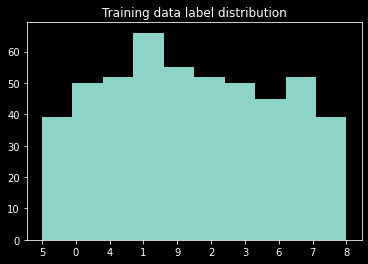

In [84]:
# Images should be shuffled in MNIST, but just to check we'll plot a histogram
plt.hist(mini_y_train)
plt.title('Training data label distribution')

Text(0.5, 1.0, 'Training data label distribution')

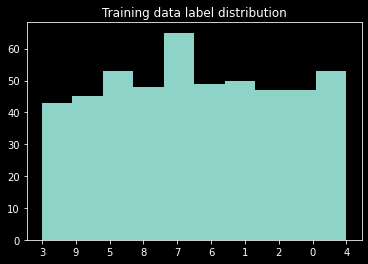

In [85]:
plt.hist(mini_y_test)
plt.title('Training data label distribution')

In [ ]:
# Now we need to standardise the data


In [120]:
mean = mini_X_train.mean(axis = 0)
mini_X_train -= mean

std = mini_X_train.std(axis = 0)
mini_X_train /= std

mini_X_test -= mean
mini_X_test /= std

We can see that numbers appear in the data set with similar frequency, so this should not be a problem

In [86]:
# We can use the face that cells have indices
index_array = mini_X_train.index.values

In [87]:
# We need to obtain a new dataset with each combination of values
image_combinations = list(itertools.combinations(index_array, 2))
image_combinations[:10]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10)]

In [88]:
image_combinations[0][0]

0

In [89]:
# Pixel array for image A, index 0
mini_X_train.loc[image_combinations[0][0],]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

In [90]:
# Pixel array for image B, index 1
mini_X_train.loc[image_combinations[0][1],]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 1, Length: 784, dtype: float64

In [91]:
# First just try putting them one on top of the other
concatenated_dataset_X = []
concatenated_dataset_y = []

for combination in image_combinations:
#     print(combination)
    
    index_A = combination[0]
    index_B = combination[1]
    
    image_A = mini_X_train.loc[index_A,]
    image_B = mini_X_train.loc[index_B,]
    
    intermediate_label_A = mini_y_train.loc[index_A,]
    intermediate_label_B = mini_y_train.loc[index_B,]
    
    concatenated_images = np.concatenate((np.array(image_A.values),np.array(image_B.values)), axis = 0)
    
    final_label = min(intermediate_label_A, intermediate_label_B)
    
#     print("image_A\n"+ str(image_A))
#     print("image_B\n"+ str(image_B))
#     print("Concatenated image\n"+ str(len(concatenated_images)))
#     print("label_A\n"+ str(intermediate_label_A))
#     print("label_B\n"+ str(intermediate_label_B))
#     print("Final_label\n"+ str(final_label))
    
    concatenated_dataset_X.append(concatenated_images)
    concatenated_dataset_y.append(final_label)
    
#     if i == 20:
#         break
    
    
#     i = i+1

In [95]:
index_array = mini_X_test.index.values
image_combinations = list(itertools.combinations(index_array, 2))
image_combinations[0:10]

[(60500, 60501),
 (60500, 60502),
 (60500, 60503),
 (60500, 60504),
 (60500, 60505),
 (60500, 60506),
 (60500, 60507),
 (60500, 60508),
 (60500, 60509),
 (60500, 60510)]

In [107]:
index_array = mini_X_test.index.values
image_combinations = list(itertools.combinations(index_array, 2))

# First just try putting them one on top of the other
concatenated_dataset_X_test = []
concatenated_dataset_y_test = []

for combination in image_combinations:
#     print(combination)
    
    index_A = combination[0]
    index_B = combination[1]
    
    image_A = mini_X_test.loc[index_A,]
    image_B = mini_X_test.loc[index_B,]
    
    intermediate_label_A = mini_y_test.loc[index_A,]
    intermediate_label_B = mini_y_test.loc[index_B,]
    
    concatenated_images = np.concatenate((np.array(image_A.values),np.array(image_B.values)), axis = 0)
    
    final_label = min(intermediate_label_A, intermediate_label_B)
    
    concatenated_dataset_X_test.append(concatenated_images)
    concatenated_dataset_y_test.append(final_label)

In [136]:
np.array(concatenated_dataset_X_test).shape

(124750, 1568)

In [134]:
np.array(one_hot_test_labels).shape

(124750, 10)

In [111]:
# Take a look at the data
concatenated_dataset_X[:3]

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [113]:
# Take a look at the output
concatenated_dataset_y[:3]

['0', '4', '1']

In [115]:
# Let's now one-hot encode the labels
one_hot_train_labels = to_categorical(concatenated_dataset_y)
one_hot_test_labels = to_categorical(concatenated_dataset_y_test)

In [142]:
np.array(concatenated_dataset_X).shape[1]

1568

In [159]:
# See if a simple neural network will work
model = tf.keras.Sequential()
model.add(layers.Dense(128, activation = 'relu',
                          input_shape=(1568,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

Softmax is used as the final layer because we want to output probabilities over the 10 possible digits

In [160]:
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [161]:
# Use only some of the test data as validation data. TODO 

In [162]:
array_concatenated_dataset_X = np.array(concatenated_dataset_X)
array_concatenated_dataset_X.shape

(124750, 1568)

In [164]:
array_one_hot_train_labels = np.array(one_hot_train_labels)
print(array_one_hot_train_labels.shape)

array_concatenated_dataset_X_test = np.array(concatenated_dataset_X_test)
print(array_concatenated_dataset_X_test.shape)

array_one_hot_test_labels = np.array(one_hot_test_labels)
print(array_one_hot_test_labels.shape)

(124750, 10)
(124750, 1568)
(124750, 10)


We use cateforical_crossentropy here as this calculates the distance between two probability distributions, here: the distribution output by the network and the true distribution of the labels

In [165]:
# Let's not train the network for 20 epochs
history = model.fit(array_one_hot_train_labels,
                    array_one_hot_train_labels,
                    epochs = 20,
                    batch_size = 16)

Epoch 1/20


ValueError: in user code:

    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 1568 but received input with shape (None, 10)
